In [1]:
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

s = [s for s in mp.rcParams.keys() if 'linewidth' in s]

for ss in s:
    mp.rcParams[ss] = .5

data courtesy of [NOAA](https://www.ncei.noaa.gov/access/crn/qcdatasets.html)

In [6]:
noaa_data = pd.read_csv('../../data/openmodelica/CRNHE0101-NC_Asheville_8_SSW.csv', index_col='DATE_TIME')
print(noaa_data.head())
print(noaa_data.describe())

            WBANNO  LONGITUDE  LATITUDE  RELATIVE_HUMIDITY  SURFACE_PRESSURE  \
DATE_TIME                                                                      
2000111505   53877     -82.61     35.49                NaN             926.3   
2000111506   53877     -82.61     35.49                NaN             926.4   
2000111507   53877     -82.61     35.49                NaN             926.6   
2000111508   53877     -82.61     35.49                NaN             926.8   
2000111509   53877     -82.61     35.49                NaN             926.9   

            SOLAR_RADIATION  ESTIMATED_10_METER_WIND_SPEED  \
DATE_TIME                                                    
2000111505              NaN                            1.2   
2000111506              NaN                            0.8   
2000111507              NaN                            0.7   
2000111508              NaN                            1.1   
2000111509              NaN                            1.1   

    

In [7]:
print(noaa_data.index.min())
print(noaa_data.index.max())

2000111505
2024021614


In [8]:
noaa_data = noaa_data[noaa_data.index >= 2004010101] # Select dates after 1 January 2024
noaa_data = noaa_data[['APPARENT_TEMPERATURE_C','RELATIVE_HUMIDITY','SURFACE_PRESSURE','SOLAR_RADIATION','ESTIMATED_10_METER_WIND_SPEED','DRY_BULB_TEMPERATURE_C']]
noaa_data.rename(columns={"APPARENT_TEMPERATURE_C" : "T_out", "RELATIVE_HUMIDITY" : "RH_out", "SURFACE_PRESSURE" : "P_out", "SOLAR_RADIATION" : "I_glob", "ESTIMATED_10_METER_WIND_SPEED" : "u_wind", "DRY_BULB_TEMPERATURE_C" : "T_sky"}, inplace=True)
print(noaa_data)

            T_out  RH_out  P_out  I_glob  u_wind  T_sky
DATE_TIME                                              
2004010101   -3.6    78.0  936.8     0.0     0.5   -1.4
2004010102   -4.8    82.0  937.2     0.0     0.4   -2.6
2004010103   -5.2    85.0  937.5     0.0     0.4   -3.0
2004010104   -5.6    88.0  937.2     0.0     0.8   -3.1
2004010105   -5.7     0.0  937.0     0.0     0.6   -3.4
...           ...     ...    ...     ...     ...    ...
2024021610    2.9    85.0  926.4     0.0     0.2    4.2
2024021611    2.1    88.0  925.8     0.0     0.3    3.4
2024021612    1.1    91.0  924.4     0.0     0.0    2.4
2024021613    0.2    93.0  925.4     1.0     0.0    1.6
2024021614    2.0    88.0  925.4    52.4     0.0    3.2

[176438 rows x 6 columns]


Check for missing values

In [9]:
print('\033[1mTotal no. of NAs\033[0m \n', noaa_data.isna().sum(), sep='', end='\n\n')
print('\033[1mTotal no. of 0s\033[0m \n', (noaa_data == 0).sum(axis=0), sep='', end='\n\n')

print('\033[1mPercentage of NAs\033[0m \n', noaa_data.isna().sum()/len(noaa_data), sep='', end='\n\n')
print('\033[1mPercentage of 0s\033[0m \n', (noaa_data == 0).sum(axis=0)/len(noaa_data), sep='')

Total no. of NAs 
T_out     645
RH_out    535
P_out      22
I_glob    535
u_wind    535
T_sky     645
dtype: int64

Total no. of 0s 
T_out      1799
RH_out    19962
P_out      1710
I_glob    87775
u_wind    32152
T_sky      1804
dtype: int64

Percentage of NAs 
T_out     0.003656
RH_out    0.003032
P_out     0.000125
I_glob    0.003032
u_wind    0.003032
T_sky     0.003656
dtype: float64

Percentage of 0s 
T_out     0.010196
RH_out    0.113139
P_out     0.009692
I_glob    0.497484
u_wind    0.182228
T_sky     0.010225
dtype: float64


In [10]:
print(noaa_data.describe())

               T_out         RH_out          P_out         I_glob  \
count  175793.000000  175903.000000  176416.000000  175903.000000   
mean       11.738133      66.256204     920.120075     149.502344   
std        10.574263      30.879302      91.184621     253.910399   
min       -23.600000       0.000000       0.000000       0.000000   
25%         3.200000      49.000000     925.900000       0.000000   
50%        12.900000      76.000000     929.400000       0.100000   
75%        20.400000      93.000000     932.600000     179.700000   
max        37.300000      99.000000     948.600000    1092.000000   

              u_wind          T_sky  
count  175903.000000  175793.000000  
mean        0.899330      12.127979  
std         0.866035       9.098122  
min         0.000000     -20.100000  
25%         0.100000       5.100000  
50%         0.600000      13.300000  
75%         1.500000      19.100000  
max         5.000000      36.400000  


<h3> Impute NOAA data </h3>

there are relatively few NA values relative to the size of the dataset. Missing values appear to also sometimes be represented by a zero, considering measuring zero for relative humidity and pressure is impossible. Zeros in `t_out`, `t_sky`, `u_wind`, and `I_glob` appear to be legitimate however.

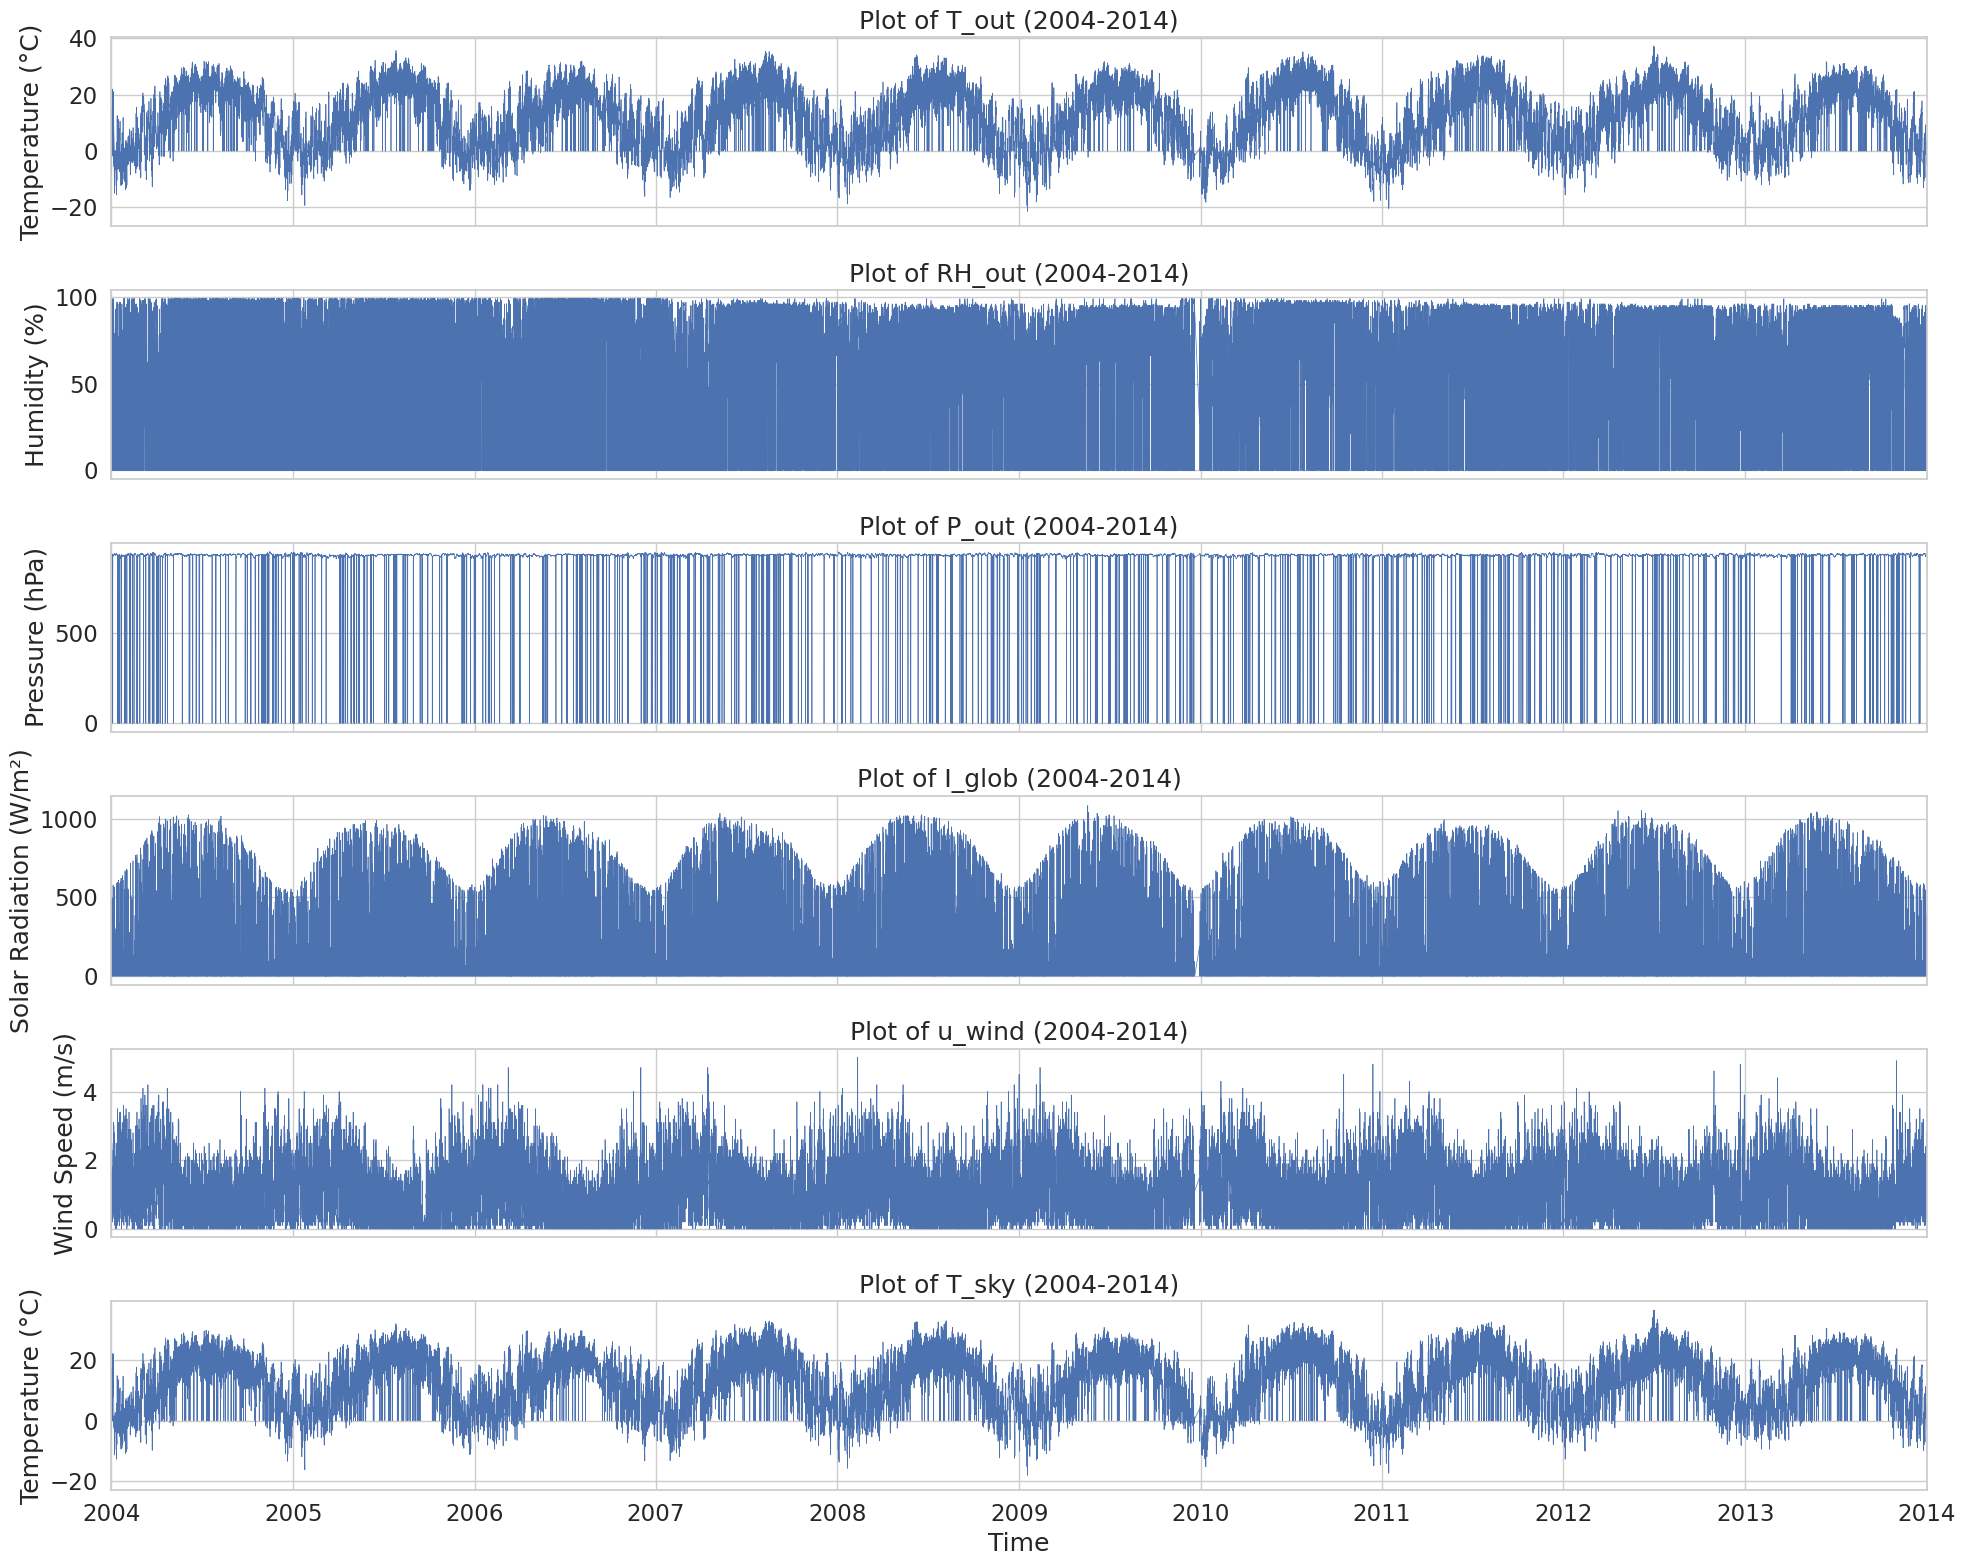

In [14]:
noaa_data_dropped_nan = noaa_data.dropna()
time_series = pd.to_datetime(noaa_data_dropped_nan.index, format='%Y%m%d%H')

sns.set(style="whitegrid", font_scale=1.5)
fig, axs = plt.subplots(6,1,figsize=(20,16), sharex=True)
fig.subplots_adjust(hspace=0.2)

y_labels = ['Temperature (°C)', 'Humidity (%)', 'Pressure (hPa)', 'Solar Radiation (W/m²)', 'Wind Speed (m/s)', 'Temperature (°C)']
for i in range(len(noaa_data_dropped_nan.columns)):
    sns.lineplot(x=time_series, y=noaa_data_dropped_nan.iloc[:,i], ax=axs[i], linewidth=0.5)
    
    axs[i].set_xlim([pd.to_datetime('2004-01-01'), pd.to_datetime('2014-01-01')])
    axs[i].set_title(f'Plot of {noaa_data_dropped_nan.columns[i]} (2004-2014)')
    axs[i].set_ylabel(y_labels[i])

plt.xlabel('Time')

plt.tight_layout()
plt.show()#savefig('../../imgs/openmodelica/NOAA_raw_data.pdf', format='pdf', transparent=True)

Using regression imputation, remove the datapoints that are NA or 0. Ignore global irradiance as 0 value is definitely expected there

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

df = noaa_data.copy()
df.replace(0, np.nan, inplace=True)

imputer = IterativeImputer(min_value=0, random_state=123, max_iter=10, initial_strategy='mean')

regr_imputed_data = imputer.fit_transform(df)
regr_imputed_data = pd.DataFrame(regr_imputed_data, columns=noaa_data.columns, index=noaa_data.index)

/home/mjmc2/.local/lib/python3.10/site-packages/sklearn/impute/_iterative.py:800: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [16]:
print(regr_imputed_data.isna().sum())

T_out     0
RH_out    0
P_out     0
I_glob    0
u_wind    0
T_sky     0
dtype: int64


remove relative humidity values above 100 as this is also impossible

In [17]:
regr_imputed_data['RH_out'] = regr_imputed_data['RH_out'].clip(upper=100)

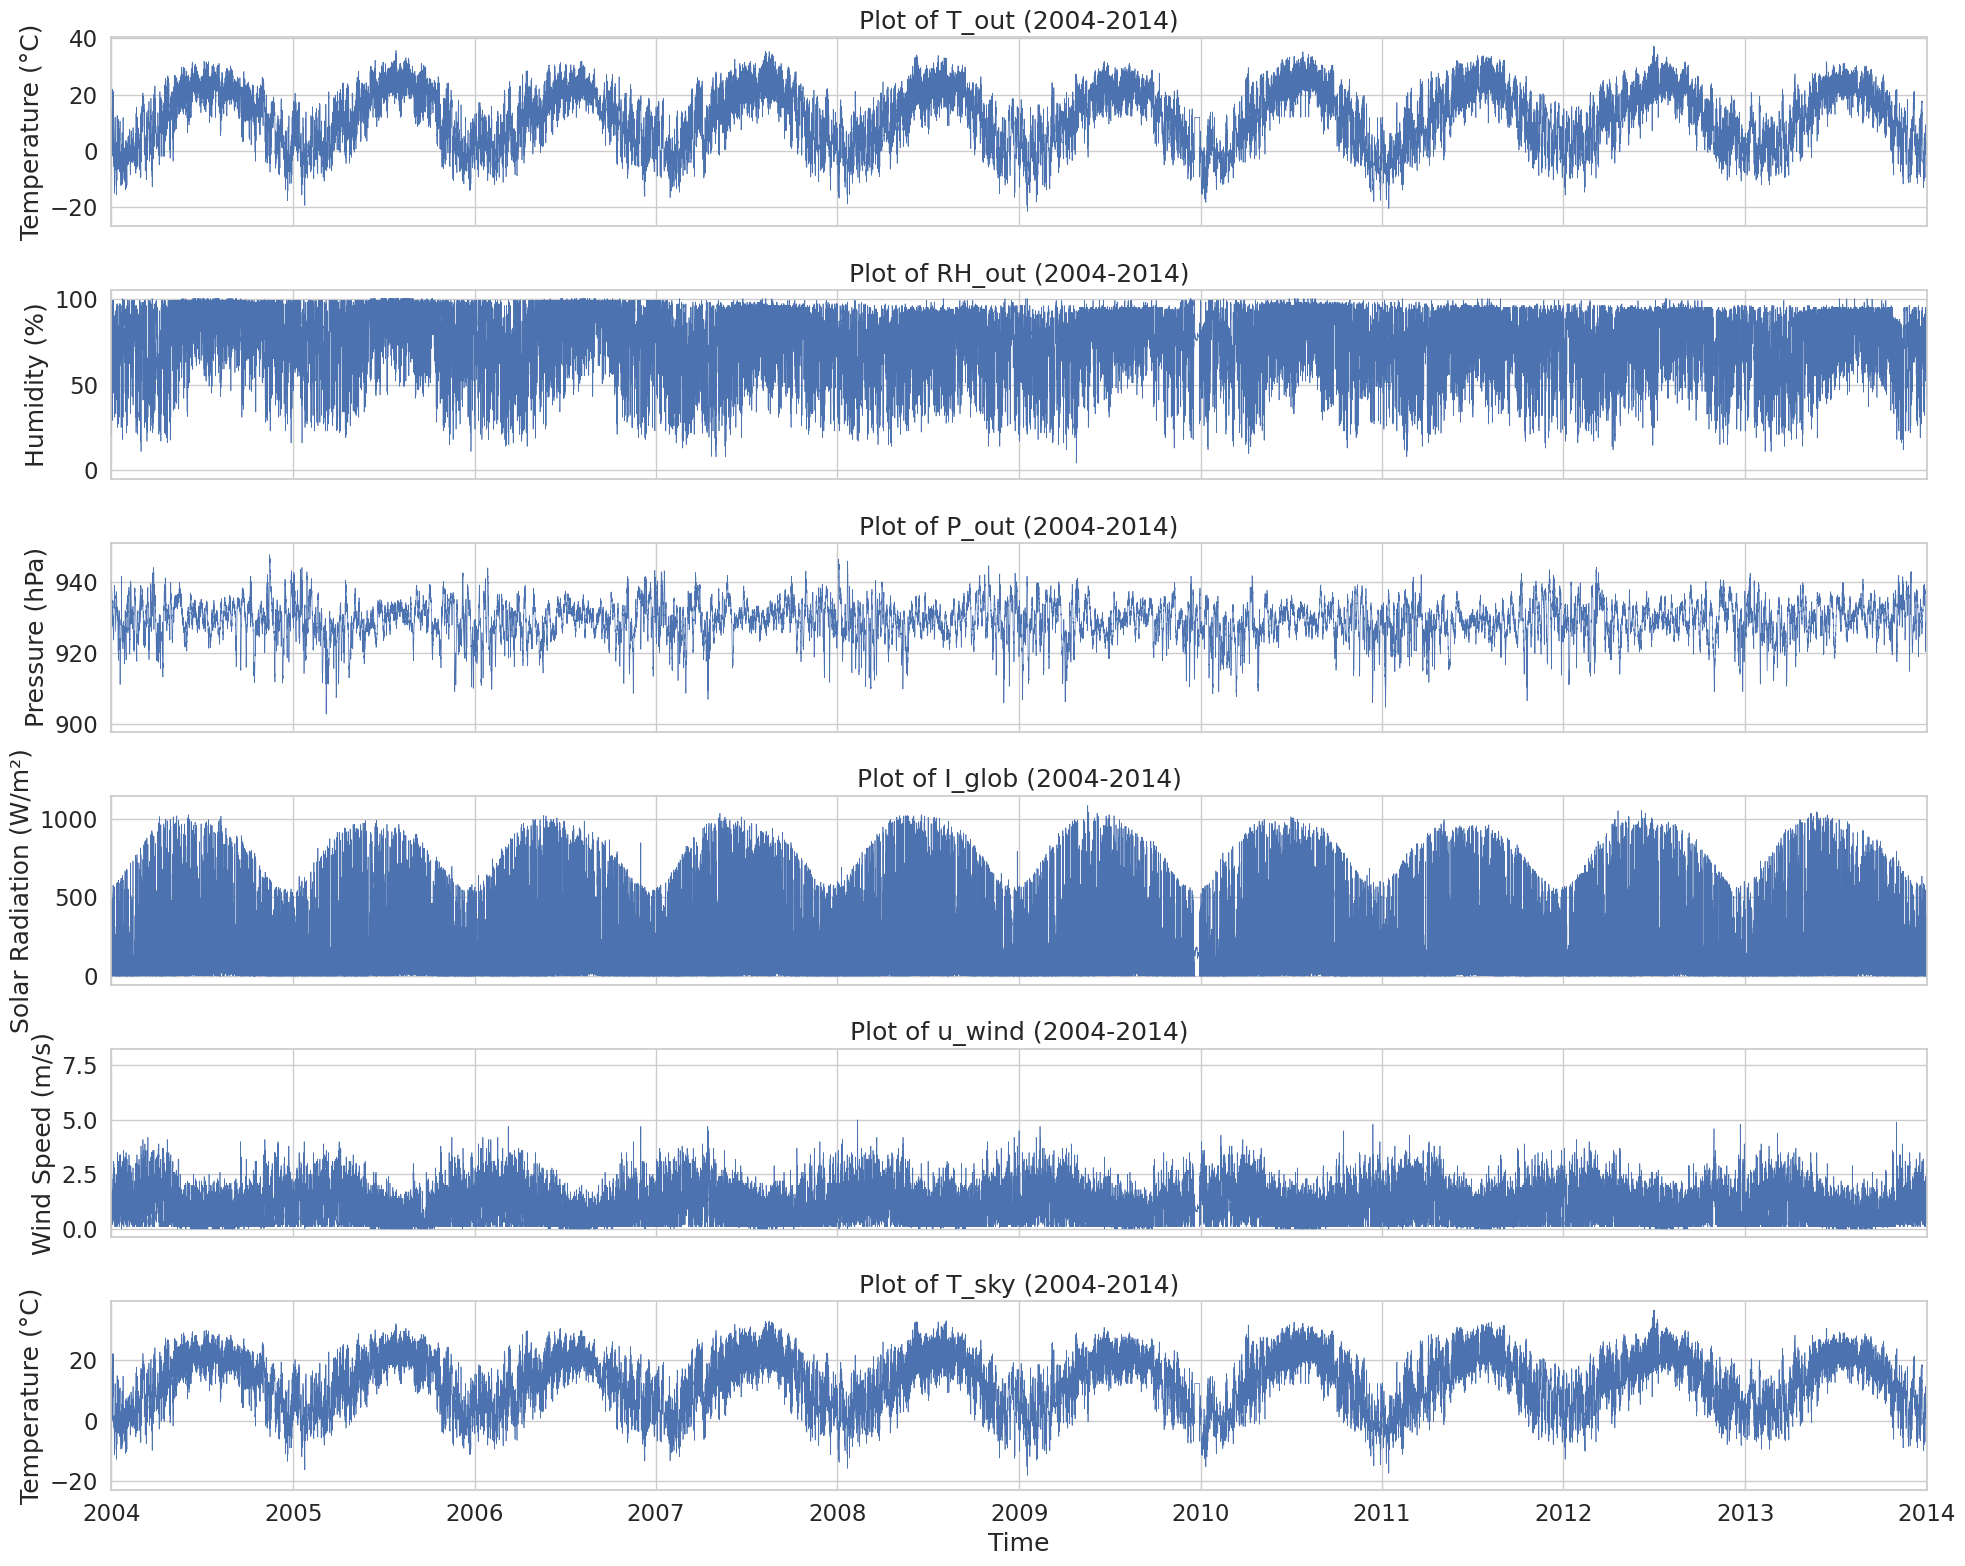

In [20]:
data = regr_imputed_data.copy()

time_series = pd.to_datetime(data.index, format='%Y%m%d%H')

sns.set(style="whitegrid", font_scale=1.5)
fig, axs = plt.subplots(6,1,figsize=(20,16), sharex=True)
fig.subplots_adjust(hspace=0.2)

y_labels = ['Temperature (°C)', 'Humidity (%)', 'Pressure (hPa)', 'Solar Radiation (W/m²)', 'Wind Speed (m/s)', 'Temperature (°C)']
for i in range(len(data.columns)):
    sns.lineplot(x=time_series, y=data.iloc[:,i], ax=axs[i], linewidth=0.5)
    
    axs[i].set_xlim([pd.to_datetime('2004-01-01'), pd.to_datetime('2014-01-01')])
    axs[i].set_title(f'Plot of {data.columns[i]} (2004-2014)')
    axs[i].set_ylabel(y_labels[i])

plt.xlabel('Time')

plt.tight_layout()
plt.show()#savefig('../../imgs/openmodelica/NOAA_imputed_data.pdf', format='pdf', transparent=True)

In [19]:
regr_imputed_data = regr_imputed_data.set_index(time_series)
df = pd.DataFrame(regr_imputed_data)
df.index.names = ['time']
print(df)
df.to_csv('../../data/openmodelica/imputed_weather_data.csv')

                     T_out     RH_out  P_out  I_glob    u_wind  T_sky
time                                                                 
2004-01-01 01:00:00   -3.6  78.000000  936.8     0.0  0.500000   -1.4
2004-01-01 02:00:00   -4.8  82.000000  937.2     0.0  0.400000   -2.6
2004-01-01 03:00:00   -5.2  85.000000  937.5     0.0  0.400000   -3.0
2004-01-01 04:00:00   -5.6  88.000000  937.2     0.0  0.800000   -3.1
2004-01-01 05:00:00   -5.7  83.963346  937.0     0.0  0.600000   -3.4
...                    ...        ...    ...     ...       ...    ...
2024-02-16 10:00:00    2.9  85.000000  926.4     0.0  0.200000    4.2
2024-02-16 11:00:00    2.1  88.000000  925.8     0.0  0.300000    3.4
2024-02-16 12:00:00    1.1  91.000000  924.4     0.0  0.687709    2.4
2024-02-16 13:00:00    0.2  93.000000  925.4     1.0  0.682631    1.6
2024-02-16 14:00:00    2.0  88.000000  925.4    52.4  0.709673    3.2

[176438 rows x 6 columns]



KeyboardInterrupt



<h3> Import original OpenModelica weather data</h3>

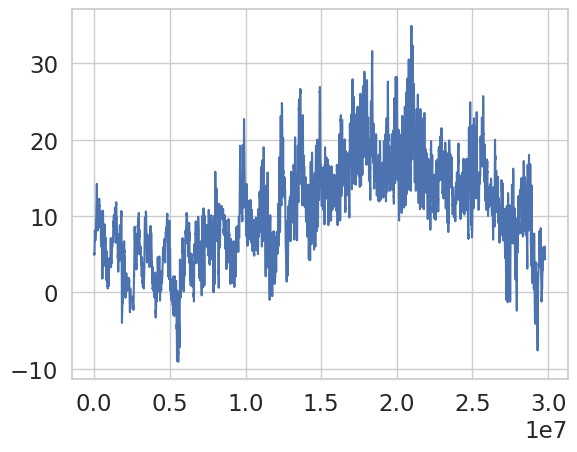

In [21]:
old_weather_data = pd.read_csv('../../data/openmodelica/10Dec-22Nov.csv', index_col=['time'])
plt.plot(old_weather_data['T_out'])

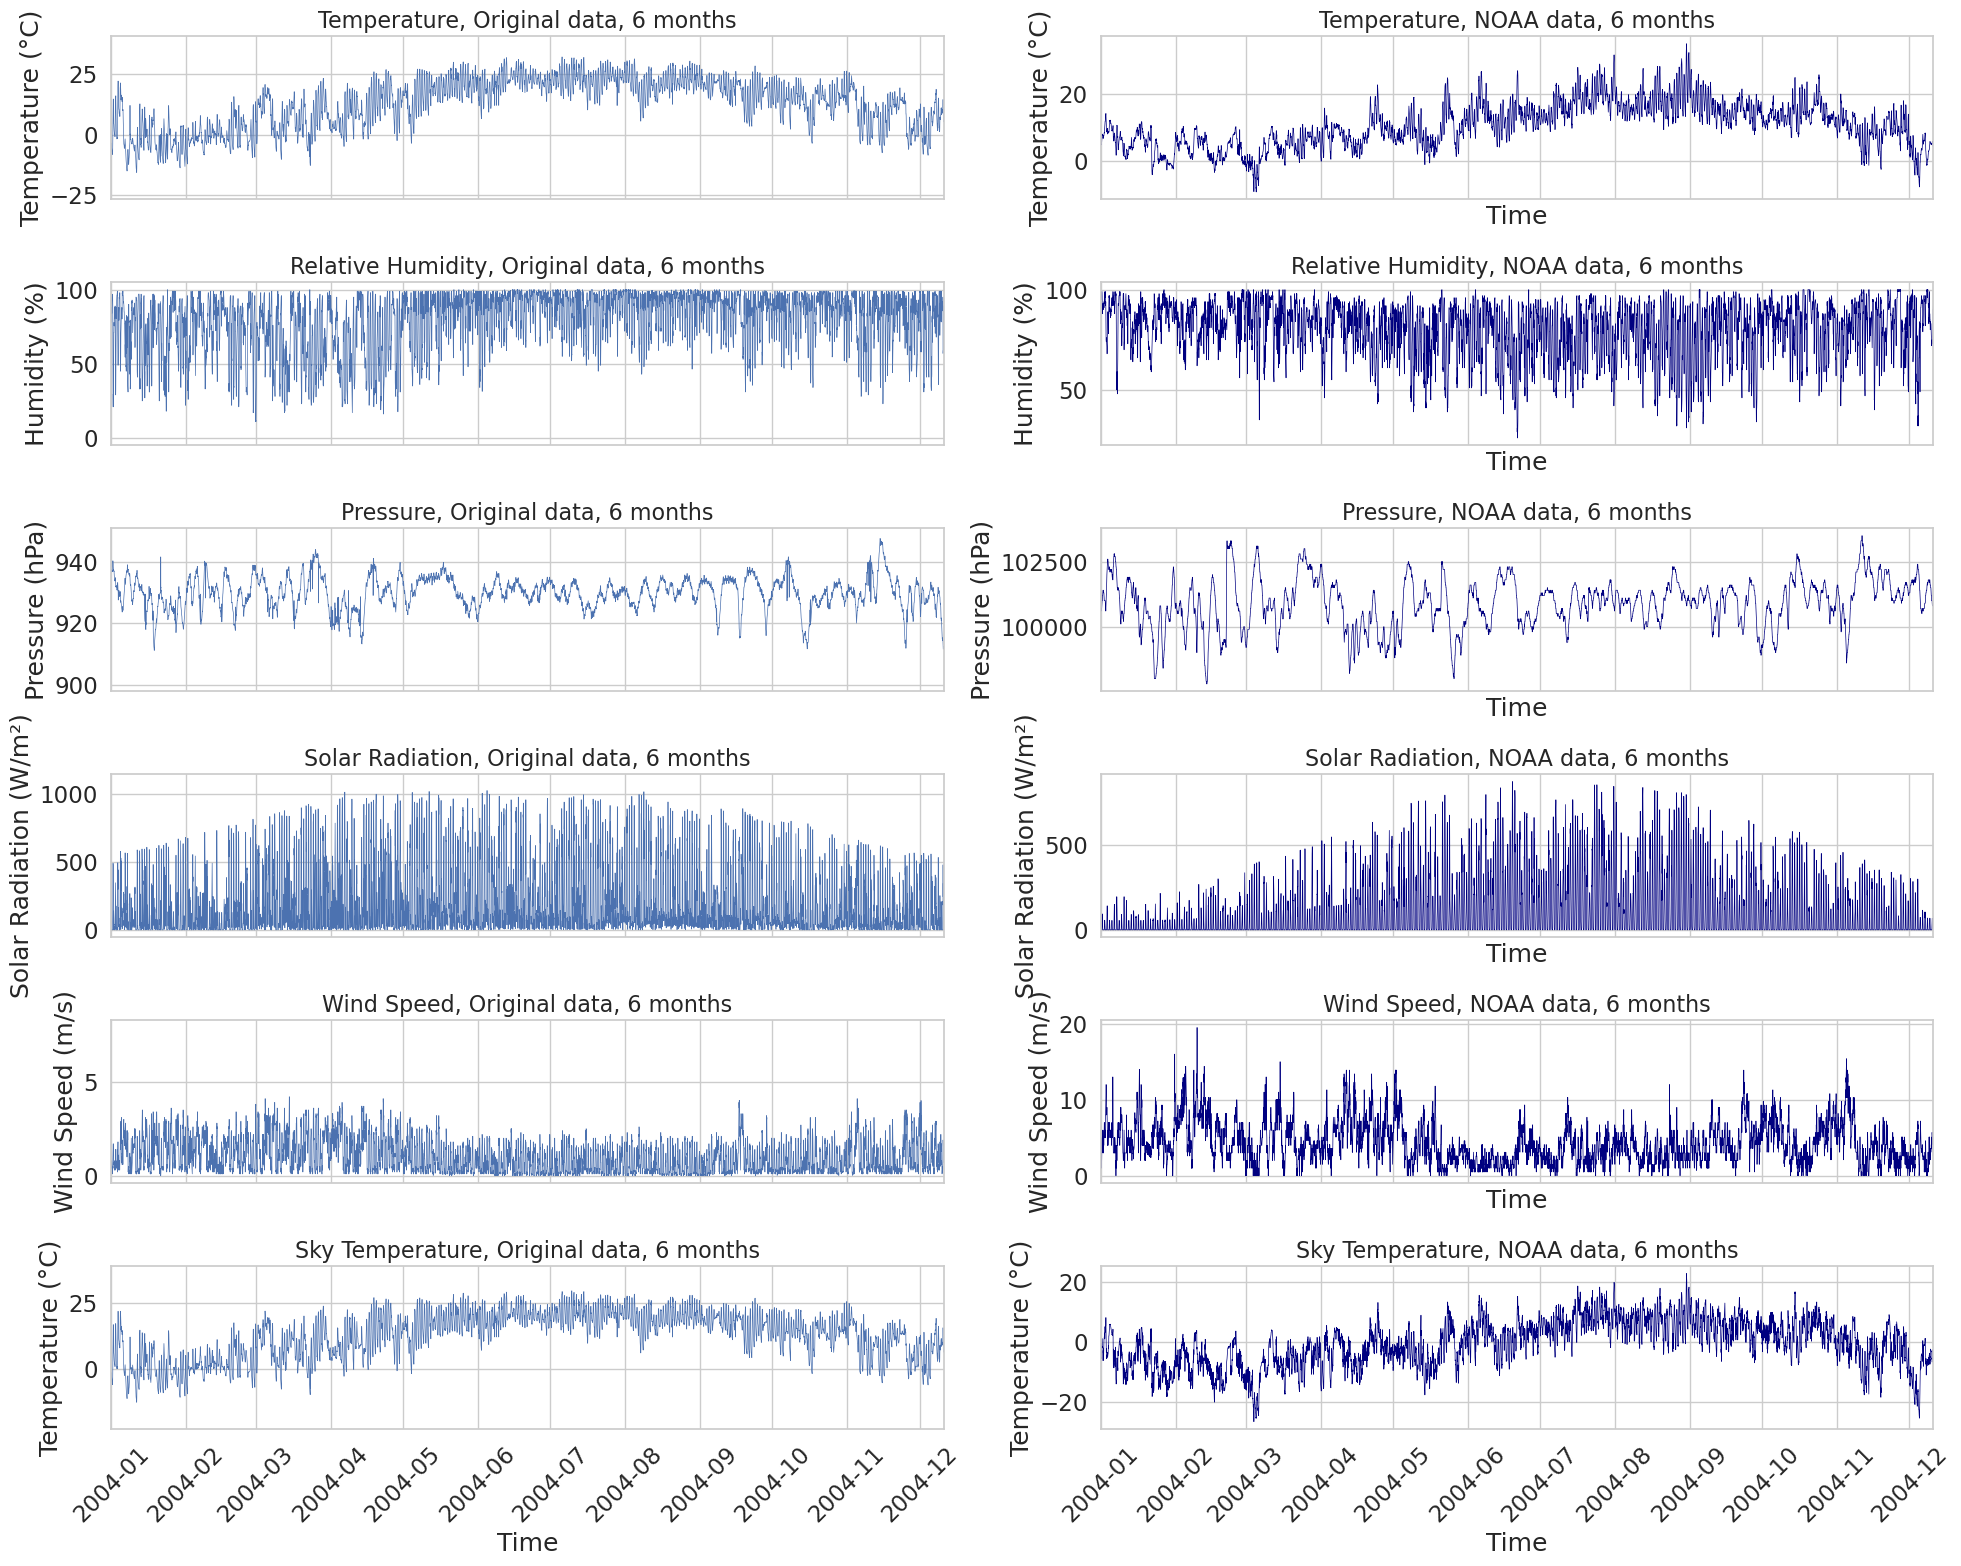

In [25]:
data = regr_imputed_data.copy()
original_data = old_weather_data.copy()

sns.set(style="whitegrid", font_scale=1.5)

time_series = pd.to_datetime(data.index, format='%Y%m%d%H')
original_time_series = pd.date_range(start='2004-01-01', periods=len(original_data['T_out']), freq='H')
fig, axs = plt.subplots(6, 2, figsize=(20,16), sharex=True)
fig.subplots_adjust(hspace=0.4, wspace=0.3)

columns = ['T_out', 'RH_out', 'P_out', 'I_glob', 'u_wind', 'T_sky']
titles = ['Temperature', 'Relative Humidity', 'Pressure', 'Solar Radiation', 'Wind Speed', 'Sky Temperature']
y_labels = ['Temperature (°C)', 'Humidity (%)', 'Pressure (hPa)', 'Solar Radiation (W/m²)', 'Wind Speed (m/s)', 'Temperature (°C)']
for i in range(len(columns)):
    sns.lineplot(x=time_series, y=data[columns[i]], ax=axs[i, 0], linewidth=0.5)
    axs[i, 1].set_xlim([pd.to_datetime('2004-01-01'), pd.to_datetime('2004-06-01')])
    axs[i, 1].set_title(f'{titles[i]}, NOAA data, 6 months', fontsize=16)
    axs[i, 1].set_ylabel(y_labels[i])
    axs[i, 1].set_xlabel('Time')
    axs[i, 1].tick_params(axis='x', rotation=45)
    
    sns.lineplot(x=original_time_series[:len(old_weather_data[columns[i]])], y=old_weather_data[columns[i]], ax=axs[i, 1], color='navy', linewidth=0.5)
    axs[i, 0].set_xlim([original_time_series[0], original_time_series[len(old_weather_data[columns[i]]) - 1]]) 
    axs[i, 0].set_title(f'{titles[i]}, Original data, 6 months', fontsize=16)
    axs[i, 0].set_ylabel(y_labels[i])
    axs[i, 0].set_xlabel('Time')
    axs[i, 0].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()#savefig('../../imgs/openmodelica/NOAA_comparison_data.pdf', format='pdf', transparent=True)